tgb - 4/8/2019 
- This script aims at predicting convective heating/moistening, longwave cooling, shortwave heating and microphysical tendencies based on the 8 column SPCAM simulation, with the goal of testing generalization abilities of different network architectures.  
- Notably, we would like to compare the generalization abilities of the conserving network (C), the unconstrained network (U) and the weakly-constrained network (W) with climate change (trained & validated on 0K and then statistics on the +4K simulation).  
- Another aspect is the "data greediness" of each network. Do we need less data when we train with constraints?
Notebook 009 follows the notebook 005 that predicts:
***
[PHQ, PHCLDLIQ, PHCLDICE, TPHYSTND, QRL, QRS, DTVKE, FSNT, FSNS, FLNT, FLNS, PRECT, PRECTEND, PRECST, PRECSTEN] as a function of:  
[QBP, QCBP, QIBP, TBP, VBP, Qdt_adiabatic, QCdt_adiabatic, QIdt_adiabatic, Tdt_adiabatic, Vdt_adiabatic, PS, SOLIN, SHFLX, LHFLX] 

## 1) Preprocess all the necessary variables

In [9]:
#!ln -s /filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/cbrain \
#/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.cam_constants import *
from cbrain.models import *
from cbrain.losses import *
from cbrain.utils import limit_mem
import tensorflow as tf
import tensorflow.math as tfm
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import xarray as xr
import numpy as np
# Otherwise tensorflow will use ALL your GPU RAM for no reason
limit_mem()
TRAINDIR = '/local/Tom.Beucler/SPCAM_PHYS/'
DATADIR = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/'
PREFIX = '8col009_01_'
%cd /filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM

/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM


tgb - 4/8/2019 - We change the pre-processing configuration file "8col_rad_tbeucler_local.yml" & because we now train on the 8 column data, we change the prefix to 8col009_01_train.  
Follows the April 4th, 2019 commit of https://github.com/raspstephan/CBRAIN-CAM/blob/master/quickstart.ipynb

In [10]:
!python preprocessing.py -c pp_config/8col_rad_tbeucler_local.yml \

GitPython not found. Please install for better reproducibility.
Traceback (most recent call last):
  File "/home/t/Tom.Beucler/miniconda3/lib/python3.6/site-packages/xarray/backends/file_manager.py", line 137, in acquire
    file = self._cache[self._key]
  File "/home/t/Tom.Beucler/miniconda3/lib/python3.6/site-packages/xarray/backends/lru_cache.py", line 43, in __getitem__
    value = self._cache[key]
KeyError: [<function _open_netcdf4_group at 0x14f756ea22f0>, ('/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/AndKua_aqua_SPCAM3.0_sp_fbp_f4.cam2.h1.0000-01-01-00000.nc', CombinedLock([<SerializableLock: e9725e13-141e-4f0a-973f-8ff0612da063>, <SerializableLock: 8e8c3784-77ec-46fa-bb85-237200eb3b8b>])), 'r', (('clobber', True), ('diskless', False), ('format', 'NETCDF4'), ('group', None), ('persist', False))]

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "cbrain/Test01_preprocess_aqua.py", line 655, in <module>
    main

### 1.4) Change the output's normalization using pressure levels

In [ ]:
ds = xr.open_dataset(TRAINDIR + PREFIX + 'train_norm.nc')  

# Open the pickle files containing the pressure converters
with open(os.path.join('/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/cbrain', 'hyai_hybi.pkl'), 'rb') as f:
            hyai, hybi = pickle.load(f)
# Takes representative value for PS since purpose is normalization
PS = 1e5; P0 = 1e5;
P = P0*hyai+PS*hybi; # Total pressure [Pa]
dP = P[1:]-P[:-1]; # Differential pressure [Pa]  
  
dt = 30*60; # timestep
ds.target_conv[:210] = np.multiply(ds.target_conv[:210],np.concatenate((dP,dP,dP,dP,dP,dP,np.divide(dP,dt))))
print(ds.target_conv)
  
# Copy old normalization file
path1 = os.path.join(TRAINDIR,PREFIX+'train_norm.nc')
path2 = os.path.join(TRAINDIR,PREFIX+'train_oldnorm.nc')
!cp $path1 $path2  
  
# Create new dataset with characteristics of modified ds
new_ds = xr.Dataset({
            'feature_means': ds.feature_means,
            'feature_stds': ds.feature_stds,
            'feature_mins': ds.feature_mins,
            'feature_maxs': ds.feature_maxs,
            'target_means': ds.target_means,
            'target_stds': ds.target_stds,
            'target_mins': ds.target_mins,
            'target_maxs': ds.target_maxs,
            'feature_names': ds.feature_names,
            'target_names': ds.target_names,
            'feature_stds_by_var': ds.feature_stds_by_var,
            'target_conv': ds.target_conv
        })  
  
# 4.3 Write new data set to initial target_conv file
!rm $path1 # Remove normalization file  
new_ds.to_netcdf(path1) # Save the new dataset as the new normalization file

# 4.4 Close the xarray handler
xr.open_dataset(path1).close() # Don't forget to close xarray handler!!

## 2) Create data generator and produce data sample


### 2.1) Create data generator from training dataset

In [19]:
train_gen_obj = DataGenerator(
    data_dir=TRAINDIR, 
    feature_fn=PREFIX+'train_shuffle_features.nc',
    target_fn=PREFIX+'train_shuffle_targets.nc',
    batch_size=512,
    norm_fn=PREFIX+'train_norm.nc',
    fsub='feature_means',   # Subtracct the mean
    fdiv='feature_stds_by_var',    # Then divide by Std
    tmult='target_conv',    # For targets/output: use values from preprocess_aqua.
    shuffle=True,
)

Generator will have 42369024 samples in 82752 batches
Features have shape 304; targets have shape 218


In [20]:
gen = train_gen_obj.return_generator()
# Produce data sample
x, y = next(gen)
# and check its shape
x.shape, y.shape

((512, 304), (512, 218))

### 2.2) Create data generator from validation dataset and produce sample

In [21]:
valid_gen_obj = DataGenerator(
    data_dir=TRAINDIR, 
    feature_fn=PREFIX+'valid_shuffle_features.nc',
    target_fn=PREFIX+'valid_shuffle_targets.nc',
    batch_size=512,
    norm_fn=PREFIX+'train_norm.nc',
    fsub='feature_means',   # Subtracct the mean
    fdiv='feature_stds_by_var',    # Then divide by Std
    tmult='target_conv',    # For targets/output: use values from preprocess_aqua.
    shuffle=True,
)

Generator will have 30875648 samples in 60304 batches
Features have shape 304; targets have shape 218


In [22]:
validgen = valid_gen_obj.return_generator()

xval, yval = next(validgen)

xval.shape, yval.shape

((512, 304), (512, 218))

### 2.3) Load all the normalization variables

In [23]:
# 1) Open the file containing the normalization of the targets
ds = xr.open_dataset(TRAINDIR + PREFIX + 'train_norm.nc')
# 2) Open the pickle files containing the pressure converters
with open(os.path.join('/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/cbrain', 'hyai_hybi.pkl'), 'rb') as f:
            hyai, hybi = pickle.load(f)
# 3) Define fsub, fdiv, normq
fsub = ds.feature_means.values
fdiv = ds.feature_stds_by_var.values
normq = ds.target_conv.values
print('fsub.shape=',fsub.shape)
print('fdiv.shape=',fdiv.shape)
print('normq.shape=',normq.shape)
print('hyai.shape=',hyai.shape)
print('hybi.shape=',hybi.shape)

ds.close()

fsub.shape= (304,)
fdiv.shape= (304,)
normq.shape= (218,)
hyai.shape= (31,)
hybi.shape= (31,)


# 3) Build neural networks

## 3.1) Formulate different models

### 4.1.1) Mass/energy conserving model (C)

In [25]:
# Conserving model with 5 dense layers
inp = Input(shape=(304,))
densout = Dense(512, activation='linear')(inp)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (4):
    densout = Dense(512, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
densout = Dense(214, activation='linear')(densout)
densout = LeakyReLU(alpha=0.3)(densout)
sradout = SurRadLay(
    input_shape=(214,), fsub=fsub, fdiv=fdiv, normq=normq,\
    hyai=hyai, hybi=hybi, output_dim = 216
)([inp, densout])
massout = MasConsLay(
    input_shape=(216,), fsub=fsub, fdiv=fdiv, normq=normq,\
    hyai=hyai, hybi=hybi, output_dim = 217
)([inp, sradout])
out = EntConsLay(
    input_shape=(217,), fsub=fsub, fdiv=fdiv, normq=normq,\
    hyai=hyai, hybi=hybi, output_dim = 218
)([inp, massout])
C_rad_5dens = Model(inputs=inp, outputs=out)

### 4.1.2) Unconstrained model (U)

In [26]:
# Unconstrained model with 5 dense layers
inp = Input(shape=(304,))
densout = Dense(512, activation='linear')(inp)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (4):
    densout = Dense(512, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
densout = Dense(218, activation='linear')(densout)
out = LeakyReLU(alpha=0.3)(densout)
U_rad_5dens = Model(inputs=inp, outputs=out)

### 4.1.3) Weakly-constrained models (W)

In [27]:
# Weakly-constrained models with 5 dense layers
# alpha=0.01
inp001 = Input(shape=(304,))
densout = Dense(512, activation='linear')(inp001)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (4):
    densout = Dense(512, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
densout = Dense(218, activation='linear')(densout)
out = LeakyReLU(alpha=0.3)(densout)
W001_rad_5dens = Model(inputs=inp001, outputs=out)
# alpha=0.5
inp05 = Input(shape=(304,))
densout = Dense(512, activation='linear')(inp05)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (4):
    densout = Dense(512, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
densout = Dense(218, activation='linear')(densout)
out = LeakyReLU(alpha=0.3)(densout)
W05_rad_5dens = Model(inputs=inp05, outputs=out)
# alpha=0.99
inp099 = Input(shape=(304,))
densout = Dense(512, activation='linear')(inp099)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (4):
    densout = Dense(512, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
densout = Dense(218, activation='linear')(densout)
out = LeakyReLU(alpha=0.3)(densout)
W099_rad_5dens = Model(inputs=inp099, outputs=out)

## 4.2) Compile the models

### 4.2.1) Use mean square error as loss function

In [28]:
C_rad_5dens.compile('rmsprop','mse')

In [29]:
U_rad_5dens.compile('rmsprop','mse')

### 4.2.2) Use custom loss function

In [30]:
W001_rad_5dens.compile(loss=customLoss(inp001,fsub,fdiv,normq,hyai,hybi,alpha = 0.01),\
                       optimizer='rmsprop')

In [31]:
W05_rad_5dens.compile(loss=customLoss(inp05,fsub,fdiv,normq,hyai,hybi,alpha = 0.5),\
                       optimizer='rmsprop')

In [32]:
W099_rad_5dens.compile(loss=customLoss(inp099,fsub,fdiv,normq,hyai,hybi,alpha = 0.99),\
                       optimizer='rmsprop')

### 4.2.3) Check model summaries

In [33]:
C_rad_5dens.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 304)          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          156160      input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 512)          0           dense[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          262656      leaky_re_lu[0][0]                
__________________________________________________________________________________________________
leaky_re_l

## 4.3) Train the models

### 4.3.1) Train compiled models

In [34]:
Nep = 30
hC_rad_5dens = C_rad_5dens.fit_generator(gen, train_gen_obj.n_batches, epochs=Nep, \
                     validation_data=validgen, validation_steps= valid_gen_obj.n_batches)
hU_rad_5dens = U_rad_5dens.fit_generator(gen, train_gen_obj.n_batches, epochs=Nep, \
                     validation_data=validgen, validation_steps= valid_gen_obj.n_batches)
hW001_rad_5dens = W001_rad_5dens.fit_generator(gen, train_gen_obj.n_batches, epochs=Nep, \
                     validation_data=validgen, validation_steps= valid_gen_obj.n_batches)
hW05_rad_5dens = W05_rad_5dens.fit_generator(gen, train_gen_obj.n_batches, epochs=Nep, \
                     validation_data=validgen, validation_steps= valid_gen_obj.n_batches)
hW099_rad_5dens = W099_rad_5dens.fit_generator(gen, train_gen_obj.n_batches, epochs=Nep, \
                     validation_data=validgen, validation_steps= valid_gen_obj.n_batches)

Epoch 1/30
82752/82752 [==============================] - 1026s 12ms/step - loss: 100.5937 - val_loss: 1903.5790
Epoch 2/30
82752/82752 [==============================] - 1013s 12ms/step - loss: 88.8372 - val_loss: 3512.4910
Epoch 3/30
82752/82752 [==============================] - 1009s 12ms/step - loss: 86.9083 - val_loss: 1789.2200
Epoch 4/30
82752/82752 [==============================] - 996s 12ms/step - loss: 85.8245 - val_loss: 1884.8554
Epoch 5/30
82752/82752 [==============================] - 1001s 12ms/step - loss: 85.0742 - val_loss: 2507.8486
Epoch 6/30
82752/82752 [==============================] - 1000s 12ms/step - loss: 84.5494 - val_loss: 1861.3495
Epoch 7/30
82752/82752 [==============================] - 999s 12ms/step - loss: 84.2654 - val_loss: 2402.4472
Epoch 8/30
82752/82752 [==============================] - 996s 12ms/step - loss: 84.3278 - val_loss: 9688.1889
Epoch 9/30
82752/82752 [==============================] - 998s 12ms/step - loss: 84.0265 - val_loss: 2433.

KeyboardInterrupt: 

### 4.3.2) Save models in .h5 format

In [35]:
%cd $TRAINDIR/HDF5_DATA
!pwd
C_rad_5dens.save('C_rad2_5dens.h5')
U_rad_5dens.save('U_rad2_5dens.h5')
W001_rad_5dens.save('W001_rad2_5dens.h5')
W05_rad_5dens.save('W05_rad2_5dens.h5')
W099_rad_5dens.save('W099_rad2_5dens.h5')

/data/Tom.Beucler/SPCAM_PHYS/HDF5_DATA
/data/Tom.Beucler/SPCAM_PHYS/HDF5_DATA


### 4.3.3) Load models if already trained
tgb - 2/11/2019 - OPTIONAL: Load the models if already trained.

In [11]:
%cd $TRAINDIR/HDF5_DATA
!pwd
# C_rad_5dens.load_weights('C_rad_5dens.h5')
# U_rad_5dens.load_weights('U_rad_5dens.h5')
#W001_rad_5dens.load_weights('W001_rad_5dens.h5')
#W05_rad_5dens.load_weights('W05_rad_5dens.h5')
#W099_rad_5dens.load_weights('W099_rad_5dens.h5')

/data/Tom.Beucler/SPCAM_PHYS/HDF5_DATA
/data/Tom.Beucler/SPCAM_PHYS/HDF5_DATA


In [12]:
%cd $TRAINDIR/HDF5_DATA
!pwd
#C_rad_5dens = load_model('C_rad_5dens.h5')
#U_rad_5dens = load_model('U_rad_5dens.h5')
# W001_rad_5dens = load_model('W001_rad_5dens.h5')
# W05_rad_5dens = load_model('W05_rad_5dens.h5')
# W099_rad_5dens = load_model('W099_rad_5dens.h5')

/data/Tom.Beucler/SPCAM_PHYS/HDF5_DATA
/data/Tom.Beucler/SPCAM_PHYS/HDF5_DATA


### 4.3.4) Loss and validation curves

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.subplot(111)

for index in range (5):
    if index==0: hdict = hC_rad_5dens.history; colo = 'bo'; col = 'b'; lab = 'C';
    elif index==1: hdict = hU_rad_5dens.history; colo = 'ro'; col = 'r'; lab = 'U';
    elif index==2: hdict = hW001_rad_5dens.history; colo = 'go'; col = 'g'; lab = 'W001';
    elif index==3: hdict = hW05_rad_5dens.history; colo = 'co'; col = 'c'; lab = 'W05';
    elif index==4: hdict = hW099_rad_5dens.history; colo = 'mo'; col = 'm'; lab = 'W099';
        
    
    train_loss_values = hdict['loss']
    valid_loss_values = hdict['val_loss']
    epochs = range(1, len(train_loss_values) + 1)

    ax.plot(epochs, train_loss_values, colo, label=lab+' Train')
    ax.plot(epochs, valid_loss_values, col, label=lab+' Valid')

#plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim((0, 125))
# https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot
# for legend at the right place
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=5, fancybox=True, shadow=True); 
plt.show()

### 4.3.5) Test predictions on one batch

In [ ]:
pred_uncons = U_rad_5dens.predict_on_batch(x)
pred_cons = C_rad_5dens.predict_on_batch(x)
ind_test = 150;
plt.plot(pred_uncons[ind_test,:], label='unconstrained')
plt.plot(pred_cons[ind_test,:], label='conserving')
plt.plot(y[ind_test,:], label='truth')
plt.legend();

## 4.4) Check performances regarding mass/energy conservation and mean square error
tgb - 2/9/2019 - Adapted mass/energy conservation check to new output vector containing 60 more variables (longwave and shortwave heating profiles)

### 4.4.1) Mass/enthalpy conservation

In [36]:
def massent_check(x,y,fsub=fsub,fdiv=fdiv,normq=normq,hyai=hyai,hybi=hybi,outtype="graph"):
    import numpy as np
    # 0) Constants
    G = 9.80616; # Reference gravity constant [m.s-2]
    L_F = 3.337e5; # Latent heat of fusion of water [W.kg-1]
    L_V = 2.501e6; # Latent heat of vaporization of water [W.kg-1]
    L_S = L_F+L_V; # Latent heat of sublimation of water [W.kg-1]
    P0 = 1e5; # Reference surface pressure [Pa]   

    # WATER&ENTHALPY) Get non-dimensional pressure differences (p_tilde above)
    # In the input vector, PS is the 151st element after 
    # the first elements = [QBP, ..., VBP with shape 30*5=150]
    PS = np.add( np.multiply( x[:,300], fdiv[300]), fsub[300])
    # Reference for calculation of d_pressure is cbrain/models.py (e.g. QLayer)
    P = np.add( np.multiply( P0, hyai), \
    np.multiply( PS[:,None], hybi))
    dP = np.subtract( P[:, 1:], P[:, :-1])
    # norm_output = dp_norm * L_V/G so dp_norm = norm_output * G/L_V
    dP_NORM = np.divide( \
    np.multiply(normq[:30], \
              G),\
    L_V)
    # dp_tilde = dp/dp_norm
    dP_TILD = np.divide( dP, dP_NORM)

    # WATER.1) Calculate water vertical integral from level 1 to level 30
    WATVEC = np.multiply( dP_TILD, y[:, :30] + y[:, 30:60] + y[:, 60:90])
    WATINT = np.sum( WATVEC, axis=1)

    # WATER.2) Calculate forcing on the right-hand side (Net Evaporation-Precipitation)
    # E-P is already normalized to units W.m-2 in the output vector
    # so all we need to do is input-unnormalize LHF that is taken from the input vector
    LHF = np.add( np.multiply( x[:,303], fdiv[303]), fsub[303])
    # Note that total precipitation = PRECT + 1e-3*PRECTEND in the CAM model
    # PRECTEND already multiplied by 1e-3 in output vector so no need to redo it
    PREC = np.add( y[:, 214], y[:, 215])

    # WATER.FINAL) Residual = E-P-DWATER/DT
    WATRES = LHF-PREC-WATINT
    
    # ENTHALPY.1) Calculate net energy input from phase change and precipitation
    # PHAS = Lf/Lv*((PRECST+PRECSTEN)-(PRECT+PRECTEND))
    PHAS = np.divide( np.multiply( np.subtract(\
                                          np.add( y[:,216], y[:,217]),\
                                          np.add( y[:,214], y[:,215])),\
                                  L_F),\
                     L_V)
    
    # ENTHALPY.2) Calculate net energy input from radiation, sensible heat flux and turbulent KE
    # 2.1) RAD = FSNT-FSNS-FLNT+FLNS
    RAD = np.add(\
            np.subtract( y[:,210], y[:,211]),\
            np.subtract( y[:,213], y[:,212]))
    # 2.2) Unnormalize sensible heat flux
    SHF = np.add( np.multiply( x[:,302], fdiv[302]), fsub[302])
    # 2.3) Net turbulent kinetic energy dissipative heating is the column-integrated 
    # turbulent kinetic energy energy dissipative heating
    KEDVEC = np.multiply( dP_TILD, y[:, 180:210])
    KEDINT = np.sum( KEDVEC, axis=1)
    
    # ENTHALPY.3) Calculate tendency of normalized column water vapor due to phase change
    # 3.1) Column water vapor is the column integral of specific humidity
    PHQVEC = np.multiply( dP_TILD, y[:, :30])
    PHQINT = np.sum( PHQVEC, axis=1)
    # 3.2) Multiply by L_S/L_V to normalize (explanation above)
    SPDQINT = np.divide( np.multiply( np.subtract(\
                                                 PHQINT, LHF),\
                                    L_S),\
                       L_V)
    
    # ENTHALPY.4) Same operation for liquid water tendency but multiplied by L_F/L_V
    SPDQCINT = np.divide( np.multiply(\
                                  np.sum(\
                                         np.multiply( dP_TILD, y[:, 30:60]),\
                                         axis=1),\
                                  L_F),\
                     L_V)
    
    # ENTHALPY.5) Same operation for temperature tendency
    DTINT = np.sum( np.multiply( dP_TILD[:, :30], y[:, 90:120]), axis=1)
    
    # ENTHALPY.FINAL) Residual = SPDQ+SPDQC+DTINT-RAD-SHF-PHAS
    ENTRES = SPDQINT+SPDQCINT+DTINT-RAD-SHF-PHAS-KEDINT
    
    if outtype=="graph":
    
        import matplotlib.pyplot as plt
        from matplotlib import rc
        plt.rc('text', usetex=True)
        plt.rc('font', family='serif')

        plt.figure(num=None, figsize=(12, 3), dpi=80, facecolor='w', edgecolor='k')

        plt.subplot(121)
        plt.hist(WATRES)
        plt.xlabel(r"$\mathrm{Water\ Residual\ \left[W.m^{-2}\right]}$", fontsize=16)
        plt.ylabel(r'Number of samples', fontsize=16)
        plt.xticks(fontsize=14); plt.yticks(fontsize=14)

        plt.subplot(122)
        plt.hist(ENTRES)
        plt.xlabel(r"$\mathrm{Enthalpy\ Residual\ \left[W.m^{-2}\right]}$", fontsize=16)
        plt.ylabel(r'Number of samples', fontsize=16)
        plt.xticks(fontsize=14); plt.yticks(fontsize=14)
    
    elif outtype=="list":
    
        return WATRES,ENTRES 

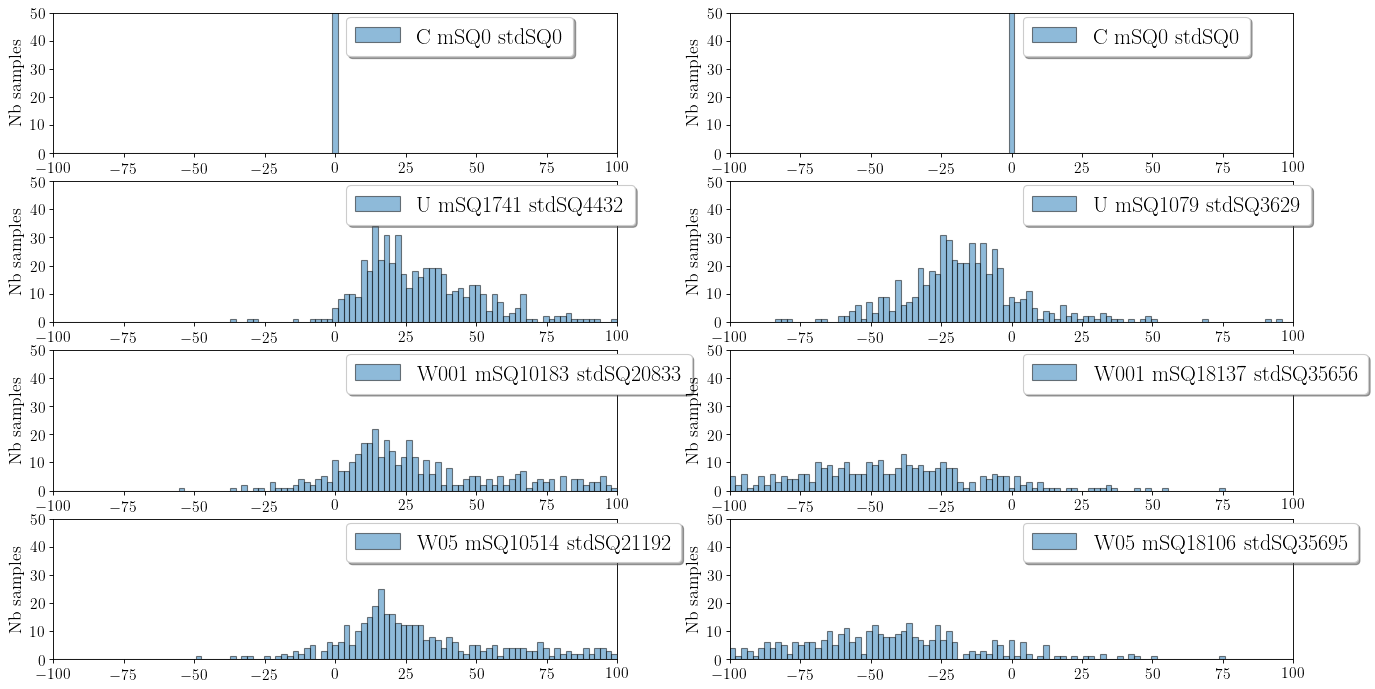

In [37]:
import matplotlib.pyplot as plt
from matplotlib import rc
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.figure(num=None, figsize=(20, 13.5), dpi=80, facecolor='w', edgecolor='k')
XMAX = 100; bins = np.linspace(-XMAX, XMAX, 100)

xval, yval = next(gen)

for index in range (4):
    if index==1: pred = U_rad_5dens.predict_on_batch(xval); lab = 'U';
    elif index==0: pred = C_rad_5dens.predict_on_batch(xval); lab = 'C';
    elif index==2: pred = W001_rad_5dens.predict_on_batch(xval); lab = 'W001';
    elif index==3: pred = W05_rad_5dens.predict_on_batch(xval); lab = 'W05';
    elif index==4: pred = W099_rad_5dens.predict_on_batch(xval); lab = 'W099';

    watres,entres = massent_check(xval,pred,fsub=fsub,fdiv=fdiv,normq=normq,hyai=hyai,hybi=hybi,outtype="list");

    ax = plt.subplot(5,2,2*index+1)
    ax.hist(watres, bins, alpha=0.5, edgecolor='k', label = lab+' mSQ%i' %np.mean(watres**2)+' stdSQ%i' %np.std(watres**2))
    plt.ylabel(r'Nb samples', fontsize=16)
    plt.xticks(fontsize=14); plt.yticks(fontsize=14)
    plt.ylim((0, 50)); plt.xlim((-XMAX, XMAX));
    ax.legend(loc='upper left', bbox_to_anchor=(0.5, 1.05),
          ncol=5, fancybox=True, shadow=True, fontsize = 20);
    
    ax = plt.subplot(5,2,2*index+2)
    ax.hist(entres, bins, alpha=0.5, edgecolor='k', label = lab+' mSQ%i' %np.mean(entres**2)+' stdSQ%i' %np.std(entres**2))
    plt.ylabel(r'Nb samples', fontsize=16)
    plt.xticks(fontsize=14); plt.yticks(fontsize=14)
    plt.ylim((0, 50)); plt.xlim((-XMAX, XMAX));
    ax.legend(loc='upper left', bbox_to_anchor=(0.5, 1.05),
          ncol=5, fancybox=True, shadow=True, fontsize = 20); 

### 4.4.2) Mean square error

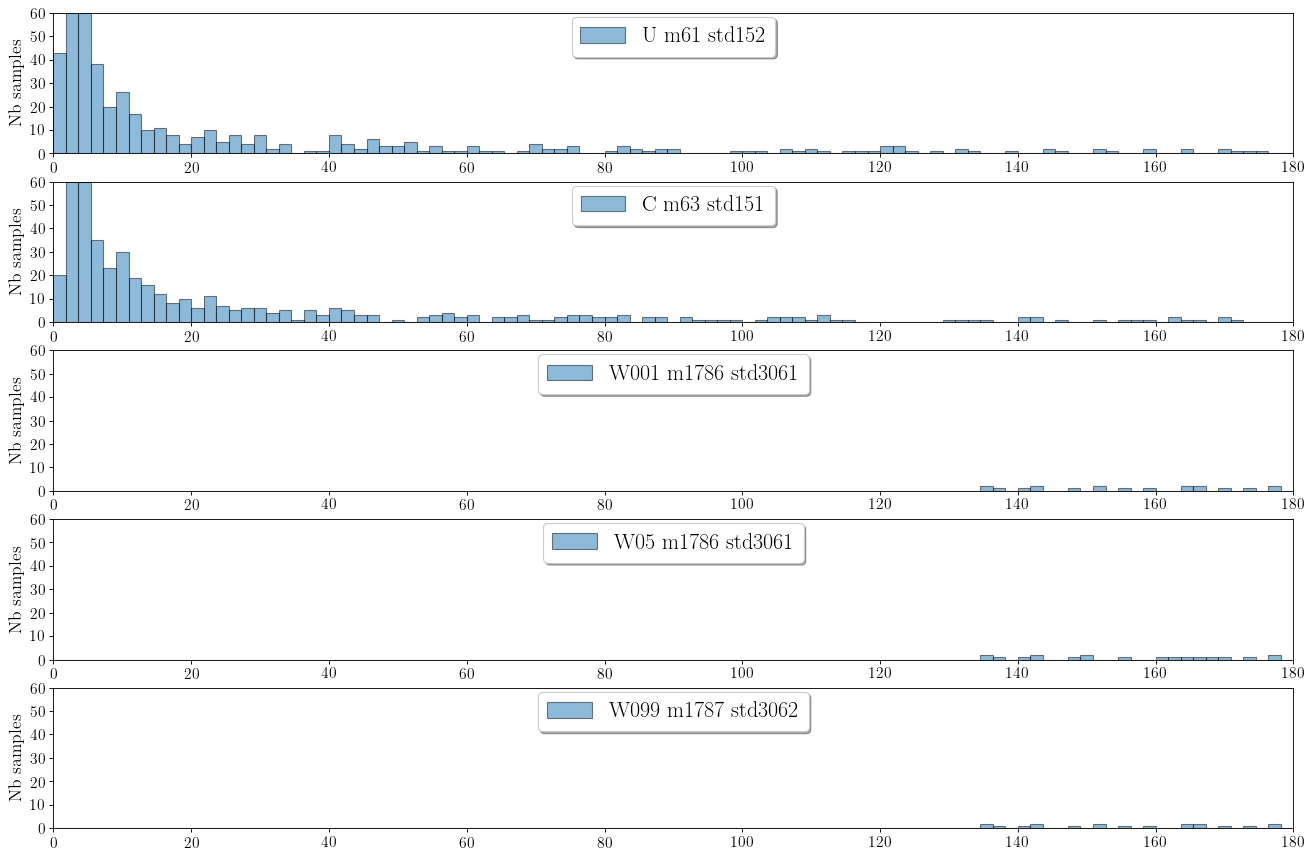

In [42]:
import matplotlib.pyplot as plt
from matplotlib import rc
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.figure(num=None, figsize=(20, 13.5), dpi=80, facecolor='w', edgecolor='k')
XMAX = 180; bins = np.linspace(0, XMAX, 100)

xval, yval = next(gen)

for index in range (5):
    if index==0: pred = U_rad_5dens.predict_on_batch(xval); lab = 'U';
    elif index==1: pred = C_rad_5dens.predict_on_batch(xval); lab = 'C';
    elif index==2: pred = W001_rad_5dens.predict_on_batch(xval); lab = 'W001';
    elif index==3: pred = W05_rad_5dens.predict_on_batch(xval); lab = 'W05';
    elif index==4: pred = W099_rad_5dens.predict_on_batch(xval); lab = 'W099';

    res = np.mean((pred-yval)**2, axis=1);
    
    ax = plt.subplot(5,1,index+1)
    ax.hist(res, bins, alpha=0.5, edgecolor='k', label = lab+' m%i' %np.mean(res)+' std%i' %np.std(res))
    plt.ylabel(r'Nb samples', fontsize=16)
    plt.xticks(fontsize=14); plt.yticks(fontsize=14)
    plt.ylim((0, 60)); plt.xlim((0, XMAX));
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=5, fancybox=True, shadow=True, fontsize = 20); 

### 4.4.3) Check radiative integrals

In [39]:
def radint_check(x,y,fsub=fsub,fdiv=fdiv,normq=normq,hyai=hyai,hybi=hybi):
    import copy
    inp = copy.copy(x)

    # 0) Constants
    C_P = 1.00464e3 # Specific heat capacity of air at constant pressure
    G = 9.80616; # Reference gravity constant [m.s-2]
    P0 = 1e5; # Reference surface pressure [Pa]

    # 1) Get non-dimensional pressure differences (p_tilde above)
    PS = np.add( np.multiply( inp[:,300], fdiv[300]), fsub[300])
    # Reference for calculation of d_pressure is cbrain/models.py (e.g. QLayer)
    P = np.add( np.multiply( P0, hyai), \
                np.multiply( PS[:,None], hybi))
    dP = np.subtract( P[:, 1:], P[:, :-1])
    # norm_output = dp_norm * L_V/G so dp_norm = norm_output * G/L_V
    dP_NORM = np.divide( \
                         np.multiply(normq[:30], \
                               G), L_V)
    # dp_tilde = dp/dp_norm
    # Wondering about broadcasting here...
    # tf.div or simply \ would support broadcasting 
    dP_TILD = np.divide( dP, dP_NORM)

    # 2) Radiative integrals
    SWVEC = np.multiply( dP_TILD, y[:, 150:180])
    SWINT = np.sum( SWVEC, axis=1)
    SWNET = y[:,210]-y[:,211] # FSNT-FSNS

    LWVEC = np.multiply( dP_TILD, y[:, 120:150])
    LWINT = np.sum( LWVEC, axis=1) # LW integral
    LWNET = y[:,213]-y[:,212] # FLNS-FLNT

    return (SWINT-SWNET), (LWINT-LWNET)

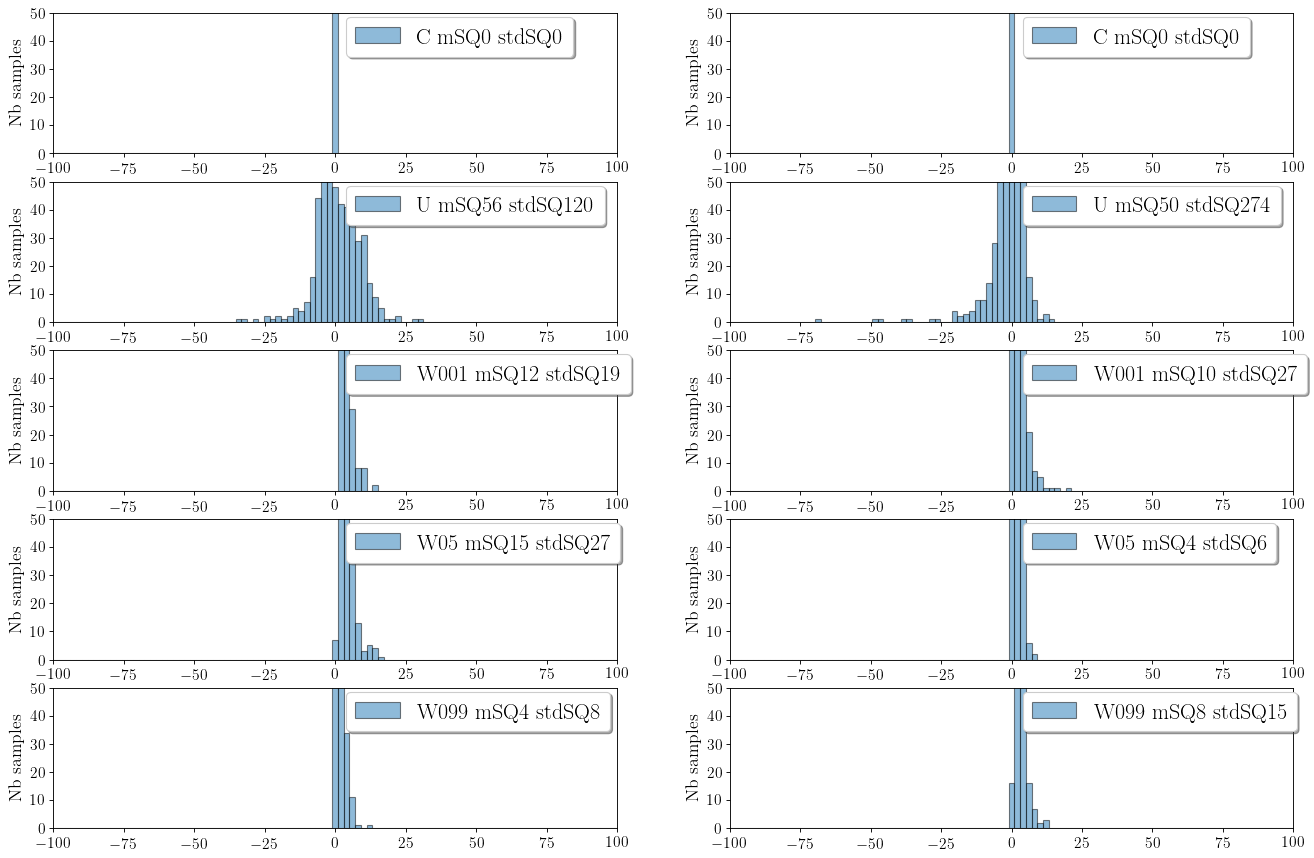

In [40]:
import matplotlib.pyplot as plt
from matplotlib import rc
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.figure(num=None, figsize=(20, 13.5), dpi=80, facecolor='w', edgecolor='k')
XMAX = 100; bins = np.linspace(-XMAX, XMAX, 100)

xval, yval = next(gen)

for index in range (5):
    if index==1: pred = U_rad_5dens.predict_on_batch(xval); lab = 'U';
    elif index==0: pred = C_rad_5dens.predict_on_batch(xval); lab = 'C';
    elif index==2: pred = W001_rad_5dens.predict_on_batch(xval); lab = 'W001';
    elif index==3: pred = W05_rad_5dens.predict_on_batch(xval); lab = 'W05';
    elif index==4: pred = W099_rad_5dens.predict_on_batch(xval); lab = 'W099';

    swres,lwres = radint_check(xval,pred,fsub=fsub,fdiv=fdiv,normq=normq,hyai=hyai,hybi=hybi)

    ax = plt.subplot(5,2,2*index+1)
    ax.hist(swres, bins, alpha=0.5, edgecolor='k', label = lab+' mSQ%i' %np.mean(swres**2)+' stdSQ%i' %np.std(swres**2))
    plt.ylabel(r'Nb samples', fontsize=16)
    plt.xticks(fontsize=14); plt.yticks(fontsize=14)
    plt.ylim((0, 50)); plt.xlim((-XMAX, XMAX));
    ax.legend(loc='upper left', bbox_to_anchor=(0.5, 1.05),
          ncol=5, fancybox=True, shadow=True, fontsize = 20);
    
    ax = plt.subplot(5,2,2*index+2)
    ax.hist(lwres, bins, alpha=0.5, edgecolor='k', label = lab+' mSQ%i' %np.mean(lwres**2)+' stdSQ%i' %np.std(lwres**2))
    plt.ylabel(r'Nb samples', fontsize=16)
    plt.xticks(fontsize=14); plt.yticks(fontsize=14)
    plt.ylim((0, 50)); plt.xlim((-XMAX, XMAX));
    ax.legend(loc='upper left', bbox_to_anchor=(0.5, 1.05),
          ncol=5, fancybox=True, shadow=True, fontsize = 20); 

#### Step 6: Check positivity of water species
There are two necessary steps:  
1) Load the water species concentrations "before physics" from the input vector and unnormalize them  
2) Invert the output normalization to get the water concentrations "after physics"

$$
\delta q_{v,i,l}\left(p\right)=\frac{L_{v}\Delta p_{\mathrm{norm}}}{g}\frac{q_{v,i,l}^{a}\left(p\right)-q_{v,i,l}^{b}\left(p\right)}{\Delta t}\ \Rightarrow\ q_{v,i,l}^{a}\left(p\right)=q_{v,i,l}^{b}\left(p\right)+\frac{g\Delta t}{L_{v}\Delta p_{\mathrm{norm}}}\delta q_{v,i,l}\left(p\right)
$$

In [ ]:
def watpos_check(x,y,fsub=fsub,fdiv=fdiv,normq=normq,dt=30*60):
    
    import numpy as np

    # 1) Extract water species concentrations from inputs
    QVB = np.add( np.multiply( x[:, :30], fdiv[ :30]), fsub[ :30])
    QLB = np.add( np.multiply( x[:, 30:60], fdiv[ 30:60]), fsub[ 30:60])
    QSB = np.add( np.multiply( x[:, 60:90], fdiv[ 60:90]), fsub[ 60:90])

    # 2) Inverse output normalization and get water concentration after physics
    QVA = QVB + np.divide( dt*y[:, :30] , normq[:30])
    QLA = QLB + np.divide( dt*y[:, 30:60] , normq[:30])
    QSA = QSB + np.divide( dt*y[:, 60:90] , normq[:30])

    import matplotlib.pyplot as plt
    from matplotlib import rc
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')

    plt.subplot(231)
    plt.hist(1e3*QVA)
    plt.xlabel(r"$\mathrm{Water\ vapor\ concentration\ \left[g/kg\right]}$", fontsize=16)
    plt.ylabel(r'Number of samples', fontsize=16)
    plt.xticks(fontsize=14); plt.yticks(fontsize=14)

    plt.subplot(232)
    plt.hist(1e3*QLA)
    plt.xlabel(r"$\mathrm{Liquid\ water\ concentration\ \left[g/kg\right]}$", fontsize=16)
    plt.xticks(fontsize=14); plt.yticks(fontsize=14)

    plt.subplot(233)
    plt.hist(1e3*QSA)
    plt.xlabel(r"$\mathrm{Ice\ concentration\ \left[g/kg\right]}$", fontsize=16)
    plt.xticks(fontsize=14); plt.yticks(fontsize=14)
    
    plt.subplot(234)
    plt.hist(1e3*(QVA-QVB))
    plt.xlabel(r"$\mathrm{Water\ vapor\ change\ \left[g/kg\right]}$", fontsize=16)
    plt.ylabel(r'Number of samples', fontsize=16)
    plt.xticks(fontsize=14); plt.yticks(fontsize=14)

    plt.subplot(235)
    plt.hist(1e3*(QLA-QLB))
    plt.xlabel(r"$\mathrm{Liquid\ water\ change\ \left[g/kg\right]}$", fontsize=16)
    plt.xticks(fontsize=14); plt.yticks(fontsize=14)

    plt.subplot(236)
    plt.hist(1e3*(QSA-QSB))
    plt.xlabel(r"$\mathrm{Ice\ change\ \left[g/kg\right]}$", fontsize=16)
    plt.xticks(fontsize=14); plt.yticks(fontsize=14)
    
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)

In [ ]:
watpos_check(xval,yval,fsub,fdiv,normq,dt)